In [1]:
%matplotlib inline

Plot Atomic Orbitals {#plot_atomic_orbitals_example}
====================

Visualize the wave functions (orbitals) of the hydrogen atom.


Import
======

Import the applicable libraries.

::: {.note}
::: {.admonition-title}
Note
:::

This example is modeled off of [Matplotlib: Hydrogen Wave
Function](http://staff.ustc.edu.cn/~zqj/posts/Hydrogen-Wavefunction/).

This example requires [sympy](https://www.sympy.org/). Install it with:

``` {.sourceCode .python}
pip install sympy
```
:::


In [2]:
import numpy as np

import pyvista as pv
from pyvista import examples

Generate the Dataset
====================

Generate the dataset by evaluating the analytic hydrogen wave function
from `sympy`.

$$\begin{equation}
\psi_{n\ell m}(r,\theta,\phi)
=
\sqrt{
\left(\frac{2}{na_0}\right)^3\, \frac{(n-\ell-1)!}{2n[(n+\ell)!]}
}
e^{-r / na_0}
\left(\frac{2r}{na_0}\right)^\ell
L_{n-\ell-1}^{2\ell+1} \cdot Y_\ell^m(\theta, \phi)
\end{equation}$$

See [Hydrogen atom](https://en.wikipedia.org/wiki/Hydrogen_atom) for
more details.

This dataset evaluates this function for the hydrogen orbital $3d_{xy}$,
with the following quantum numbers:

-   Principal quantum number: `n=3`
-   Azimuthal quantum number: `l=2`
-   Magnetic quantum number: `m=-2`


In [3]:
grid = examples.load_hydrogen_orbital(3, 2, -2)
grid

ImageData (0x7f1d04ca81c0)
  N Cells:      970299
  N Points:     1000000
  X Bounds:     -2.350e+01, 2.350e+01
  Y Bounds:     -2.350e+01, 2.350e+01
  Z Bounds:     -2.350e+01, 2.350e+01
  Dimensions:   100, 100, 100
  Spacing:      4.747e-01, 4.747e-01, 4.747e-01
  N Arrays:     2

Plot the Orbital
================

Plot the orbital using
`add_volume() <pyvista.Plotter.add_volume>`{.interpreted-text
role="func"} and using the default scalars contained in `grid`,
`real_wf`. This way we can plot more than just the probability of the
electron, but also the phase of the electron wave function.

::: {.note}
::: {.admonition-title}
Note
:::

Since the real value of evaluated wave function for this orbital varies
between `[-<value>, <value>]`, we cannot use the default opacity
`opacity='linear'`. Instead, we use `[1, 0, 1]` since we would like the
opacity to be proportional to the absolute value of the scalars.
:::


/home/kononov/venv_for_jupyter/lib/python3.11/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

Please install `ipywidgets`.

Falling back to a static output.
  warnings.warn(


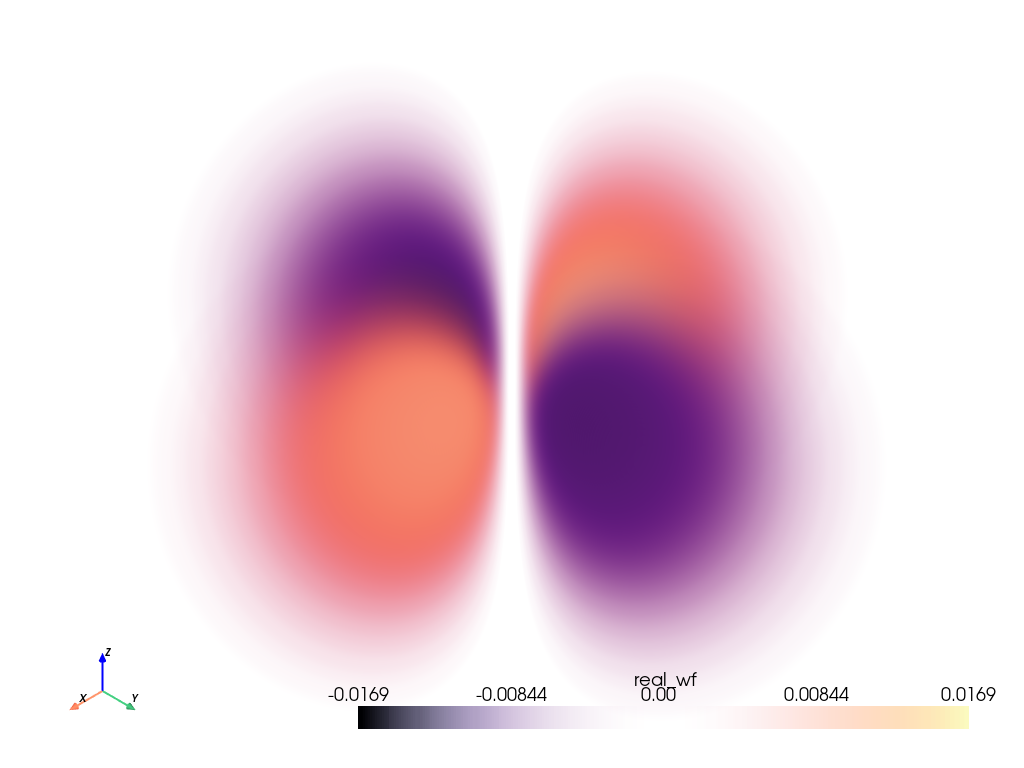

In [4]:
pl = pv.Plotter()
vol = pl.add_volume(grid, cmap='magma', opacity=[1, 0, 1])
vol.prop.interpolation_type = 'linear'
pl.camera.zoom(2)
pl.show_axes()
pl.show()

Plot the Orbital Contours as an Isosurface
==========================================

Generate the contour plot for the orbital by determining when the
orbital equals 10% the maximum value of the orbital. This effectively
captures the most likely locations of the electron for this orbital.

Note how we use the absolute value of the scalars when evaluating
`contour() <pyvista.DataSetFilters.contour>`{.interpreted-text
role="func"} to capture where the positive and negative phases cross
`eval_at`.


/home/kononov/venv_for_jupyter/lib/python3.11/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


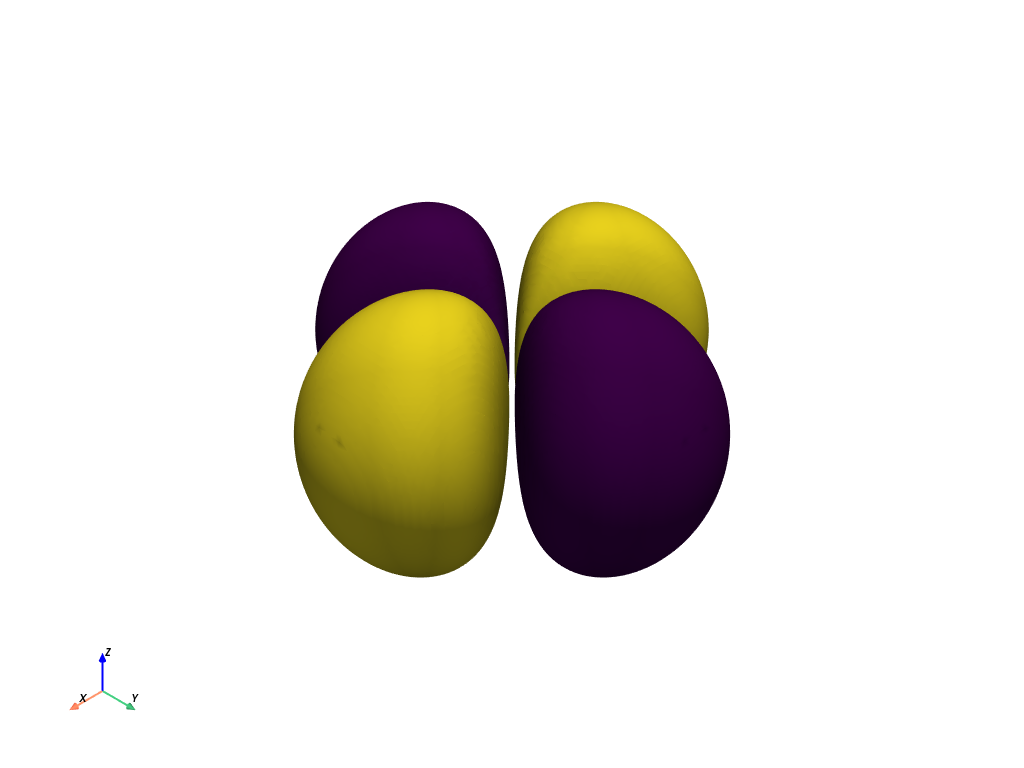

In [5]:
eval_at = grid['real_wf'].max() * 0.1
contours = grid.contour(
    [eval_at],
    scalars=np.abs(grid['real_wf']),
    method='marching_cubes',
)
contours = contours.interpolate(grid)
contours.plot(
    smooth_shading=True,
    show_scalar_bar=False,
)

Volumetric Plot: Plot the Orbitals using RGBA
=============================================

Let\'s now combine some of the best parts of the two above plots. The
volumetric plot is great for showing the probability of the \"electron
cloud\" orbitals, but the colormap doesn\'t quite match reality as well
as the isosurface plot.

For this example we\'re going to use an RGBA colormap to tightly control
the way the orbitals are plotted. For this, the opacity will be mapped
to the probability of the electron being at a location in the grid,
which we can do by taking the absolute value squared of the orbital\'s
wave function. We can set the color of the orbital based on the phase,
which we can get simply with `orbital['real_wf'] < 0`.

Let\'s start with a simple one, the $3p_z$ orbital.


In [ ]:
def plot_orbital(orbital, cpos='iso', clip_plane='x'):
    """Plot an electron orbital using an RGBA colormap."""
    neg_mask = orbital['real_wf'] < 0
    rgba = np.zeros((orbital.n_points, 4), np.uint8)
    rgba[neg_mask, 0] = 255
    rgba[~neg_mask, 1] = 255

    # normalize opacity
    opac = np.abs(orbital['real_wf']) ** 2
    opac /= opac.max()
    rgba[:, -1] = opac * 255

    orbital['plot_scalars'] = rgba

    pl = pv.Plotter()
    vol = pl.add_volume(
        orbital,
        scalars='plot_scalars',
    )
    vol.prop.interpolation_type = 'linear'
    if clip_plane:
        pl.add_volume_clip_plane(
            vol,
            normal=clip_plane,
            normal_rotation=False,
        )
    pl.camera_position = cpos
    pl.camera.zoom(1.5)
    pl.show_axes()
    return pl.show()


hydro_orbital = examples.load_hydrogen_orbital(3, 1, 0)
plot_orbital(hydro_orbital, clip_plane='-x')

Volumetric Plot: $4d_{z^2}$ orbital
===================================


In [ ]:
hydro_orbital = examples.load_hydrogen_orbital(4, 2, 0)
plot_orbital(hydro_orbital, clip_plane='-y')

Volumetric Plot: $4d_{xz}$ orbital
==================================


In [ ]:
hydro_orbital = examples.load_hydrogen_orbital(4, 2, -1)
plot_orbital(hydro_orbital, clip_plane='-y')

Plot an Orbital Using a Density Plot
====================================

We can also plot atomic orbitals using a 3D density plot. For this, we
will use `numpy.random.choice`{.interpreted-text role="func"} to sample
all the points of our `pyvista.ImageData`{.interpreted-text
role="class"} based on the probability of the electron being at that
coordinate.


In [ ]:
# Generate the orbital and sample based on the square of the probability of an
# electron being within a particular volume of space.
hydro_orbital = examples.load_hydrogen_orbital(4, 2, 0, zoom_fac=0.5)
prob = np.abs(hydro_orbital['real_wf']) ** 2
prob /= prob.sum()
indices = np.random.choice(hydro_orbital.n_points, 10000, p=prob)

# add a small amount of noise to these coordinates to remove the "grid like"
# structure present in the underlying ImageData
points = hydro_orbital.points[indices]
points += np.random.random(points.shape) - 0.5

# Create a point cloud and add the phase as the active scalars
point_cloud = pv.PolyData(points)
point_cloud['phase'] = hydro_orbital['real_wf'][indices] < 0

# Turn the point cloud into individual spheres. We do this so we can improve
# the plot by enabling surface space ambient occlusion (SSAO)
dplot = point_cloud.glyph(
    geom=pv.Sphere(theta_resolution=8, phi_resolution=8), scale=False, orient=False
)

# be sure to enable SSAO here. This makes the "points" that are deeper within
# the density plot darker.
pl = pv.Plotter()
pl.add_mesh(
    dplot,
    smooth_shading=True,
    show_scalar_bar=False,
    cmap=['red', 'green'],
    ambient=0.2,
)
pl.enable_ssao(radius=10)
pl.enable_anti_aliasing()
pl.camera.zoom(2)
pl.background_color = 'w'
pl.show()

Density Plot - Gaussian Points Representation
=============================================

Finally, let\'s plot the same data using the \"Gaussian points\"
representation.


In [ ]:
point_cloud.plot(
    style='points_gaussian',
    render_points_as_spheres=False,
    point_size=3,
    emissive=True,
    background='k',
    show_scalar_bar=False,
    cpos='xz',
    zoom=2,
)